Tried on the torch example, with linear layer
can be successfully extracted

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from utils_torch import plot_mnist
from models.Mnist_torch import Mnist_torch


In [2]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, 
                        transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])), batch_size=1000, shuffle=False)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )
    def forward(self, inputs):
        return self.model(inputs)

In [4]:
model = Net()
model = Mnist_torch(model)

In [5]:
model.load_weights('mnist.pth')

In [6]:
model.get_layer_outputs

{'': <torch.utils.hooks.RemovableHandle at 0x7f6934530520>,
 'model': <torch.utils.hooks.RemovableHandle at 0x7f6934530c40>,
 'model.0': <torch.utils.hooks.RemovableHandle at 0x7f69345305e0>,
 'model.1': <torch.utils.hooks.RemovableHandle at 0x7f67ef91c700>,
 'model.2': <torch.utils.hooks.RemovableHandle at 0x7f67ef91c280>,
 'model.3': <torch.utils.hooks.RemovableHandle at 0x7f67ef91c6a0>,
 'model.4': <torch.utils.hooks.RemovableHandle at 0x7f67ef91c460>,
 'model.5': <torch.utils.hooks.RemovableHandle at 0x7f67ef91c2e0>,
 'model.6': <torch.utils.hooks.RemovableHandle at 0x7f67ef91c220>,
 'model.7': <torch.utils.hooks.RemovableHandle at 0x7f67ef91c820>,
 'model.8': <torch.utils.hooks.RemovableHandle at 0x7f67ef91cc10>,
 'model.9': <torch.utils.hooks.RemovableHandle at 0x7f67ef91cca0>,
 'model.10': <torch.utils.hooks.RemovableHandle at 0x7f67ef91ccd0>,
 'model.11': <torch.utils.hooks.RemovableHandle at 0x7f67ef91cd60>,
 'model.12': <torch.utils.hooks.RemovableHandle at 0x7f67ef91ce20>}

In [7]:
dataset = torch.tensor([])
dataset_labels = torch.tensor([])
for num, (data, data_set) in enumerate(test_loader):
    if num == 0:
        dataset = torch.tensor(data)
        dataset_labels = torch.tensor(data_set)
    else:
        dataset = torch.cat((dataset, data), 0)
        dataset_labels = torch.cat((dataset_labels, data_set), 0)

/tmp/ipykernel_17013/1528009909.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.tensor(data)
/tmp/ipykernel_17013/1528009909.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset_labels = torch.tensor(data_set)


In [8]:
print(dataset.shape)
print(dataset_labels.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10000])


In [9]:
dataset_labels

tensor([7, 2, 1,  ..., 4, 5, 6])

In [10]:
for name, module in model.model.named_modules():
    print(name)


model
model.0
model.1
model.2
model.3
model.4
model.5
model.6
model.7
model.8
model.9
model.10
model.11
model.12


In [11]:
all_layer_names = [layer[0] for layer in model.model.named_modules()]
layer_name = "model.9"
layer_id = all_layer_names.index(layer_name)
print(layer_id)

11


In [12]:
import ctypes
lib_file = "index/build/lib.linux-x86_64-3.8/deepeverst_index.cpython-38-x86_64-linux-gnu.so"
index_lib = ctypes.CDLL(lib_file)

In [13]:
import math
from utils_torch import *

n_images = len(dataset)
n_partitions= 64
batch_size = 64
ratio = 0.05
bits_per_image = math.ceil(math.log(n_partitions, 2))
print(n_images)
print(type(dataset))

10000
<class 'torch.Tensor'>


In [14]:
print(dataset.shape)
layer_result = get_layer_result_by_layer_id(model, dataset, layer_id, batch_size=None)

torch.Size([10000, 1, 28, 28])


In [15]:
print(layer_result)
print(layer_result.shape)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [14.5403,  0.0000, 17.8139,  ..., 21.9381,  0.0000, 12.6076],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 6.1944,  4.3168,  0.1817,  ...,  0.0000, 11.7333,  0.0000],
        [ 0.0000,  0.0000,  3.7585,  ...,  0.0000,  0.0000,  9.8025],
        [ 5.7350, 22.6847, 12.5248,  ..., 11.7988, 14.2970, 18.9270]])
torch.Size([10000, 50])


In [16]:
layer_result = layer_result.detach().numpy()
from DeepEverest_torch import *
rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx, par_low_bound, par_upp_bound = construct_index(
        index_lib=index_lib,
        n_images=n_images,
        ratio=ratio,
        n_partitions=n_partitions,
        bits_per_image=bits_per_image,
        layer_result=layer_result)

In [17]:
label_predicted = torch.argmax(model.predict(dataset), axis=1)
print(label_predicted)

tensor([7, 2, 1,  ..., 4, 5, 6])


In [18]:
label_test = dataset_labels
print(label_test)

tensor([7, 2, 1,  ..., 4, 5, 6])


In [19]:
misclassified_mask = label_predicted[:1000] != label_test[:1000]
np.where(misclassified_mask)

(array([ 33,  62,  73, 124, 209, 233, 241, 247, 259, 290, 318, 320, 321,
        445, 448, 449, 479, 495, 511, 530, 543, 551, 571, 582, 591, 659,
        684, 689, 691, 717, 720, 740, 810, 839, 894, 898, 900, 924, 926,
        938, 947, 950, 956, 965]),)

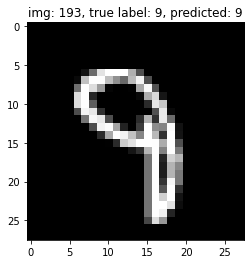

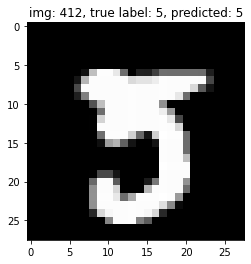

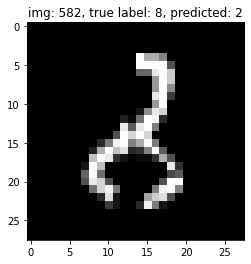

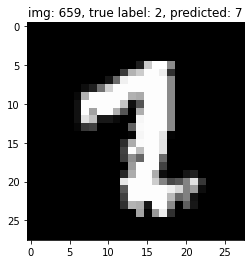

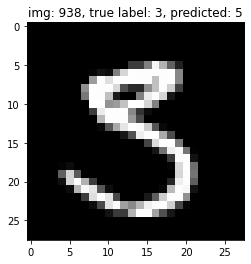

In [20]:
image_ids = [193, 412, 582, 659, 938]
for image_id in image_ids:
    prediction = torch.argmax(model.predict(dataset[image_id].reshape((1, 1, 28, 28))), axis=1)
    plot_mnist(dataset, label_test, image_id, prediction)

In [21]:
import heapq
def get_topk_activations_given_images(model, dataset, image_ids, layer_name, k):
    res = []
    image_samples = []
    for image_sample_id in image_ids:
        image_samples.append(dataset[image_sample_id])
    image_samples = torch.stack(image_samples)
    layer_result_image_samples = model.get_layer_result_by_layer_name(image_samples, layer_name)
    for idx, image_sample_id in enumerate(image_ids):
        heap = list()
        for neuron_idx, activation in np.ndenumerate(layer_result_image_samples[idx]):
            if len(heap) < k:
                heapq.heappush(heap, (activation, neuron_idx))
            elif (activation, neuron_idx) > heap[0]:
                heapq.heapreplace(heap, (activation, neuron_idx))
        res.append(sorted(heap, reverse=True))
    return res

Set the target input of interest and the number of top activations you want to inspect.  
For example, image 659 is a misclassified example in the dataset.  
Get the top-k activations for this input in this layer and their corresponding neuron IDs.

In [22]:
image_ids = [659]
k_global = 20
topk_activations = get_topk_activations_given_images(model, dataset, image_ids, layer_name, k_global)[0]
topk_activations_neurons = [x[1] for x in topk_activations]
topk_activations

[(18.500181, (22,)),
 (17.930517, (31,)),
 (12.450147, (40,)),
 (12.163991, (19,)),
 (11.593167, (11,)),
 (11.415342, (21,)),
 (10.074311, (46,)),
 (9.022502, (45,)),
 (8.759412, (23,)),
 (7.912117, (43,)),
 (6.0367236, (24,)),
 (5.741935, (42,)),
 (5.118834, (27,)),
 (5.04021, (20,)),
 (4.394094, (25,)),
 (4.0837927, (34,)),
 (3.5555177, (3,)),
 (3.0059814, (4,)),
 (0.0, (49,)),
 (0.0, (48,))]

Construct the group of neurons that you are interested in, e.g., the top-3 maximally activated neurons.

In [23]:
from NeuronGroup import *
image_sample_id = 659
neuron_group = NeuronGroup(model.model, layer_id, neuron_idx_list=topk_activations_neurons[:3])

In [24]:
dataset.shape

torch.Size([10000, 1, 28, 28])

Query for the k-nearest neighbors in the dataset using the activations of this group of neurons  
based on the proximity in the latent space defined by this group of neurons.  
answer_query_with_guarantee() runs the Neural Threshold Algorithm.

In [25]:
top_k, exit_msg, is_in_partition_0, n_images_rerun = answer_query_with_guarantee(
                                                        model, dataset, rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx,
                                                        par_low_bound, par_upp_bound, image_sample_id,
                                                        neuron_group, k_global, n_partitions, bits_per_image,
                                                        BATCH_SIZE=batch_size, batch_size=batch_size)
top_k = sorted(top_k)
top_k, exit_msg

image 659, size of neuron group 3
threshold: 28.614091873168945, max in answer: 6.4692182540893555, images run: 2921
======================= NTA exited =======================


([(-6.4692183, 6731),
  (-6.45851, 5655),
  (-6.2666936, 2671),
  (-6.242455, 111),
  (-6.2103887, 7927),
  (-6.181614, 787),
  (-6.161711, 9839),
  (-6.12134, 2480),
  (-5.9585986, 960),
  (-5.8497024, 2490),
  (-5.7205076, 7523),
  (-5.6185427, 9413),
  (-5.597579, 3575),
  (-5.072999, 435),
  (-4.8390746, 2059),
  (-4.6875644, 7375),
  (-4.385722, 4119),
  (-3.4685392, 4731),
  (-2.072644, 411),
  (0.0, 659)],
 'termination: images run: 2921')

Visualize the top-k results.

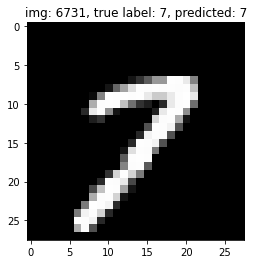

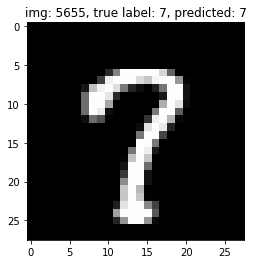

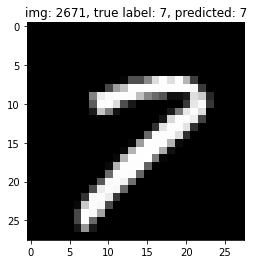

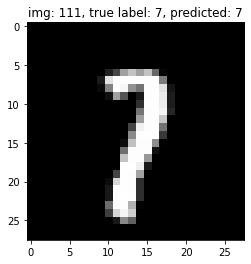

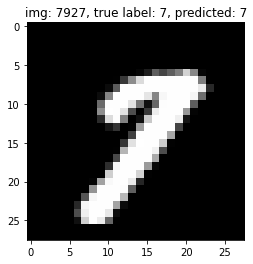

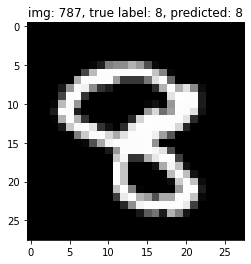

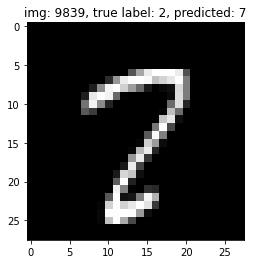

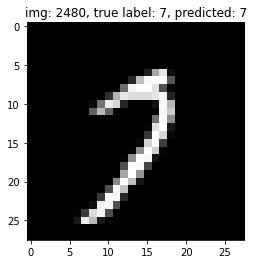

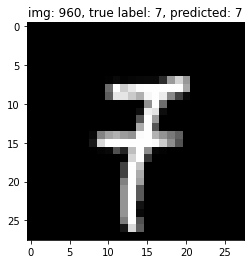

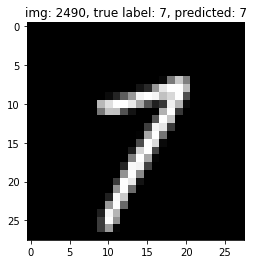

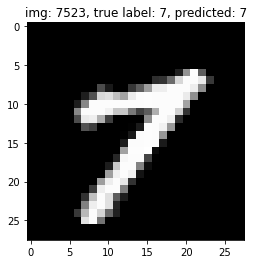

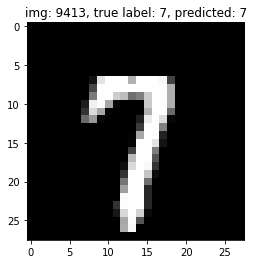

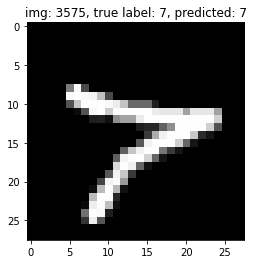

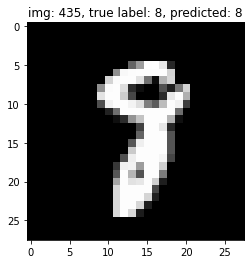

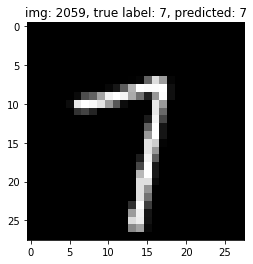

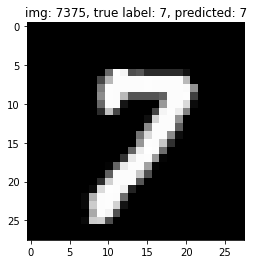

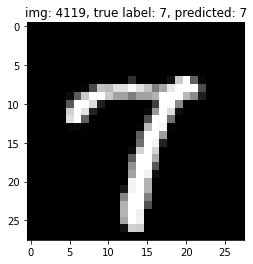

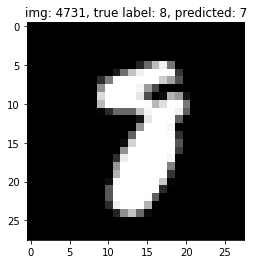

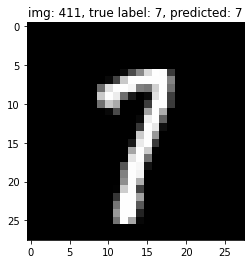

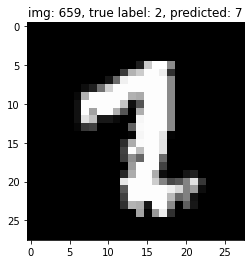

In [26]:
for neg_dist, image_id in top_k:
    prediction = torch.argmax(model.predict(dataset[image_id].reshape((1, 1, 28, 28))), axis=1).item()
    plot_mnist(dataset, dataset_labels, image_id, prediction)

In [27]:
def predict_2_as_7(image_id):
    return label_predicted[image_id] == 7 and label_test[image_id] == 2

def predict_7_as_7(image_id):
    return label_predicted[image_id] == 7 and label_test[image_id] == 7

def predict_2_as_2(image_id):
    return label_predicted[image_id] == 2 and label_test[image_id] == 2

def predict_7_as_2(image_id):
    return label_predicted[image_id] == 2 and label_test[image_id] == 7

In [28]:
seven_as_two = -1
two_as_seven = -1
two_as_two = -1
seven_as_seven = -1
for image_id in range(dataset.shape[0]):
    if seven_as_two < 0 and predict_7_as_2(image_id):
        seven_as_two = image_id
    if two_as_seven < 0 and predict_2_as_7(image_id):
        two_as_seven = image_id
    if two_as_two < 0 and predict_2_as_2(image_id):
        two_as_two = image_id
    if seven_as_seven < 0 and predict_7_as_7(image_id):
        seven_as_seven = image_id
    if seven_as_two > 0 and two_as_seven > 0 and two_as_two > 0 and seven_as_seven > 0:
        break

print(two_as_two, seven_as_seven, two_as_seven, seven_as_two)

1 0 321 810


In [29]:
image_ids = [two_as_two, seven_as_seven, two_as_seven, seven_as_two]

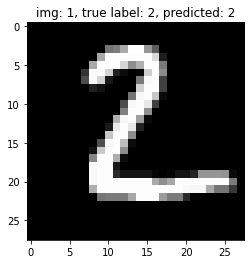

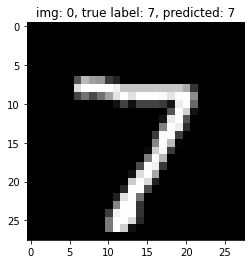

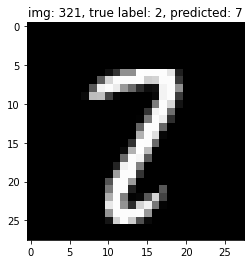

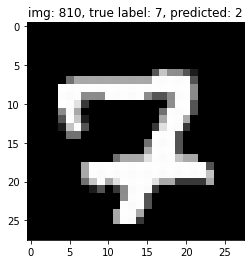

In [30]:
for image_id in image_ids:
    prediction = torch.argmax(model.predict(dataset[image_id].reshape((1, 1, 28, 28))), axis=1).item()
    plot_mnist(dataset, dataset_labels, image_id, prediction)

In [31]:
k_global = 20
topk_activations = get_topk_activations_given_images(model, dataset, image_ids, layer_name, k_global)
topk_activations

[[(39.959507, (17,)),
  (28.075613, (27,)),
  (27.041708, (30,)),
  (21.938122, (47,)),
  (21.792511, (12,)),
  (20.515385, (22,)),
  (20.364542, (28,)),
  (18.746891, (19,)),
  (18.136425, (20,)),
  (17.858646, (8,)),
  (17.813932, (2,)),
  (14.540305, (0,)),
  (13.949699, (5,)),
  (12.607556, (49,)),
  (10.404011, (11,)),
  (7.3750057, (7,)),
  (2.1416333, (24,)),
  (0.0, (48,)),
  (0.0, (46,)),
  (0.0, (45,))],
 [(35.87641, (21,)),
  (30.395935, (19,)),
  (29.095161, (40,)),
  (25.502337, (46,)),
  (25.244747, (25,)),
  (24.607574, (35,)),
  (23.167364, (20,)),
  (22.705425, (22,)),
  (17.382921, (43,)),
  (16.002148, (42,)),
  (14.013952, (45,)),
  (12.978439, (34,)),
  (12.750025, (31,)),
  (6.4843254, (37,)),
  (5.8707266, (4,)),
  (4.8972397, (11,)),
  (0.6396547, (5,)),
  (0.57390976, (3,)),
  (0.0, (49,)),
  (0.0, (48,))],
 [(26.893326, (22,)),
  (21.14046, (21,)),
  (20.501083, (19,)),
  (16.798138, (43,)),
  (16.749718, (46,)),
  (15.977177, (31,)),
  (13.0867405, (20,)),
  

In [32]:
neuron_cnt = dict()
for topk_activation in topk_activations:
    for activation, neuron_idx in topk_activation:
        if neuron_idx in neuron_cnt:
            neuron_cnt[neuron_idx] += 1
        else:
            neuron_cnt[neuron_idx] = 1

sorted_neurons = [(k, v) for k, v in sorted(neuron_cnt.items(), key=lambda item: item[1], reverse=True)]
sorted_neurons_idx = [x[0] for x in sorted_neurons]
sorted_neurons

[((22,), 4),
 ((19,), 4),
 ((20,), 4),
 ((5,), 4),
 ((11,), 4),
 ((46,), 4),
 ((45,), 4),
 ((30,), 3),
 ((28,), 3),
 ((49,), 3),
 ((21,), 3),
 ((40,), 3),
 ((25,), 3),
 ((35,), 3),
 ((43,), 3),
 ((42,), 3),
 ((34,), 3),
 ((4,), 3),
 ((17,), 2),
 ((47,), 2),
 ((48,), 2),
 ((31,), 2),
 ((3,), 2),
 ((27,), 1),
 ((12,), 1),
 ((8,), 1),
 ((2,), 1),
 ((0,), 1),
 ((7,), 1),
 ((24,), 1),
 ((37,), 1),
 ((23,), 1)]

image 810, size of neuron group 1
threshold: 21.94550323486328, max in answer: 0.2860450744628906, images run: 2449
======================= NTA exited =======================


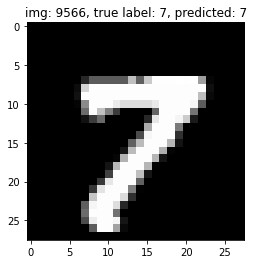

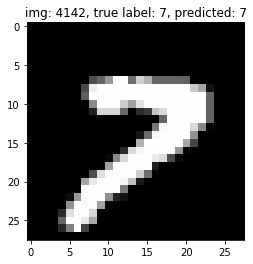

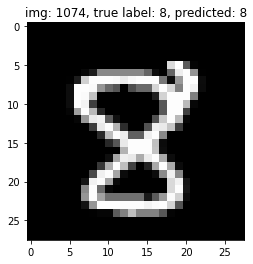

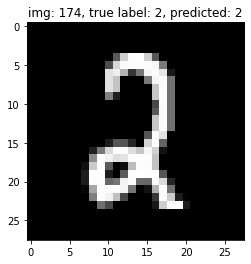

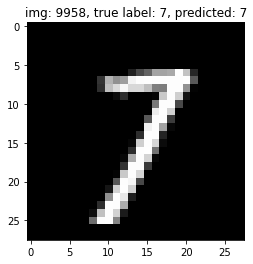

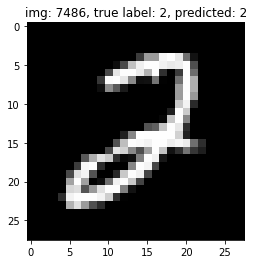

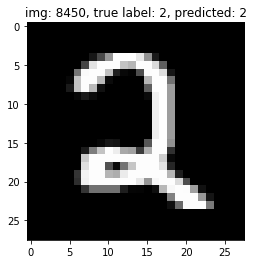

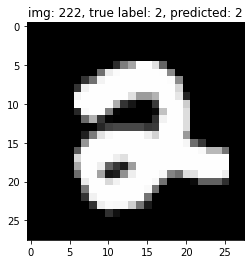

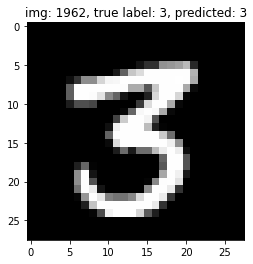

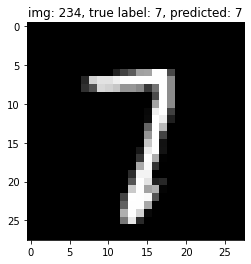

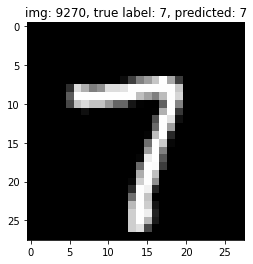

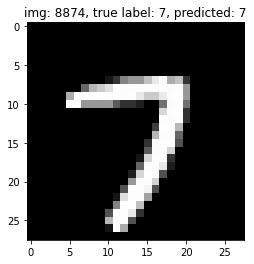

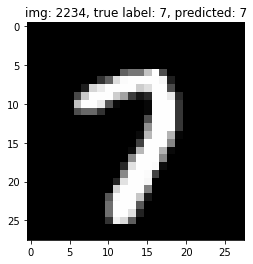

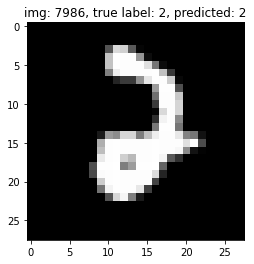

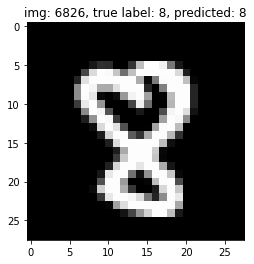

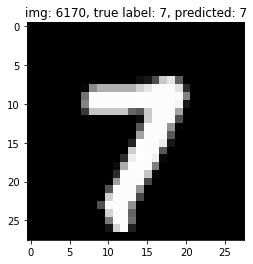

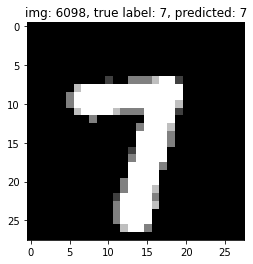

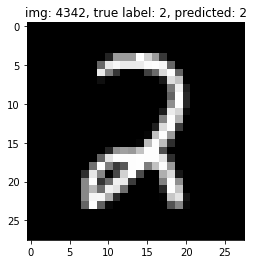

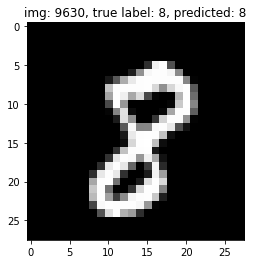

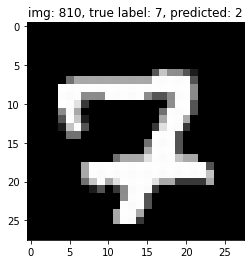

In [33]:
image_sample_id = seven_as_two
layer_id = all_layer_names.index(layer_name)
neuron_group = NeuronGroup(model.model, layer_id, neuron_idx_list=sorted_neurons_idx[:1])
top_k, exit_msg, is_in_partition_0, n_images_run = answer_query_with_guarantee(
                                                        model, dataset, rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx,
                                                        par_low_bound, par_upp_bound, image_sample_id,
                                                        neuron_group, k_global, n_partitions, bits_per_image,
                                                        BATCH_SIZE=batch_size, batch_size=batch_size)
top_k = sorted(top_k)
for neg_dist, image_id in top_k:
    prediction = torch.argmax(model.predict(dataset[image_id].reshape((1, 1, 28, 28))), axis=1).item()
    plot_mnist(dataset, dataset_labels, image_id, prediction)

image 810, size of neuron group 3
threshold: 9.163128852844238, max in answer: 2.395407199859619, images run: 2500
======================= NTA exited =======================


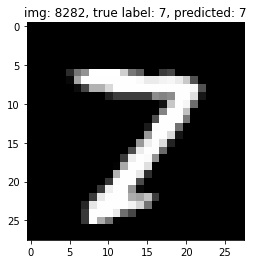

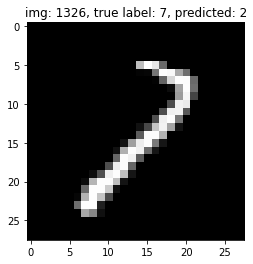

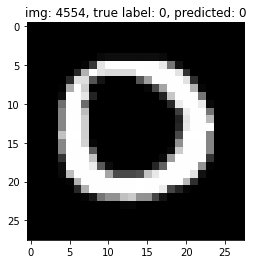

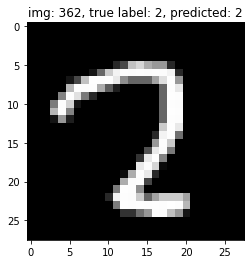

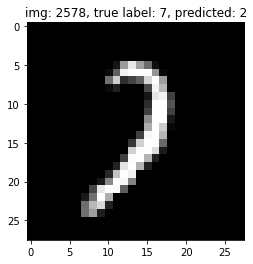

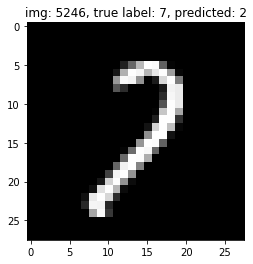

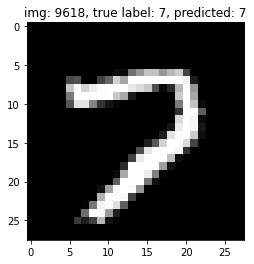

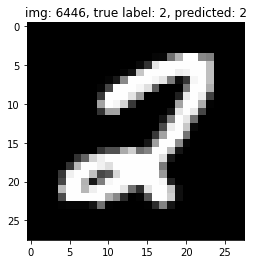

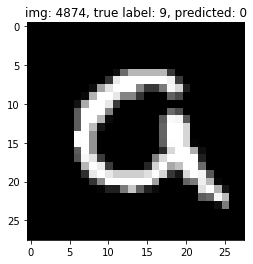

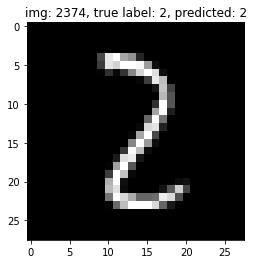

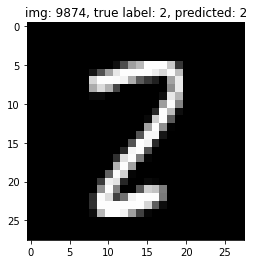

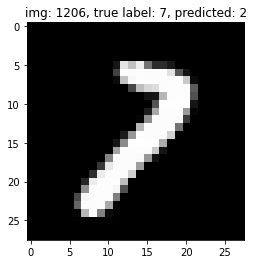

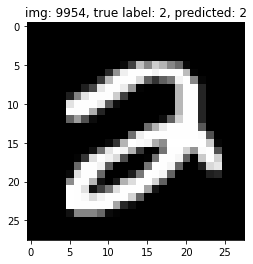

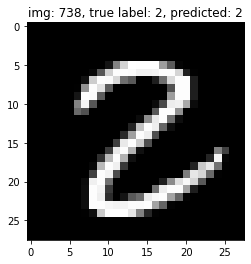

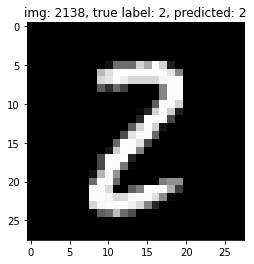

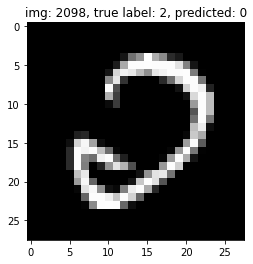

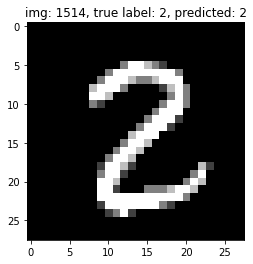

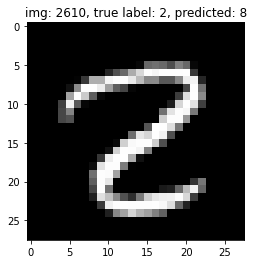

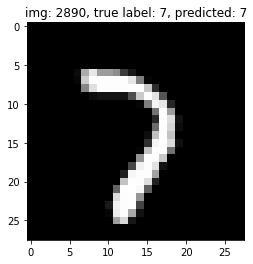

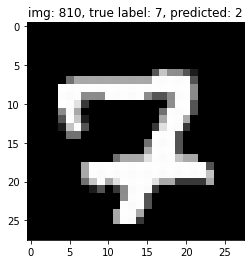

In [34]:
layer_id = all_layer_names.index(layer_name)
neuron_group = NeuronGroup(model.model, layer_id, neuron_idx_list=[(0,), (5,), (10,)])
top_k, exit_msg, is_in_partition_0, n_images_run = answer_query_with_guarantee(
                                                        model, dataset, rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx,
                                                        par_low_bound, par_upp_bound, image_sample_id,
                                                        neuron_group, k_global, n_partitions, bits_per_image,
                                                        BATCH_SIZE=batch_size, batch_size=batch_size)
top_k = sorted(top_k)
for neg_dist, image_id in top_k:
    prediction = torch.argmax(model.predict(dataset[image_id].reshape((1, 1, 28, 28))), axis=1).item()
    plot_mnist(dataset, dataset_labels, image_id, prediction)

In [35]:
confusion_activations = [topk_activations[2], topk_activations[3]]
neuron_cnt = dict()
for topk_activation in confusion_activations:
    for activation, neuron_idx in topk_activation:
        if neuron_idx in neuron_cnt:
            neuron_cnt[neuron_idx] += 1
        else:
            neuron_cnt[neuron_idx] = 1
{k: v for k, v in sorted(neuron_cnt.items(), key=lambda item: item[1], reverse=True)}

{(22,): 2,
 (21,): 2,
 (19,): 2,
 (43,): 2,
 (46,): 2,
 (20,): 2,
 (40,): 2,
 (11,): 2,
 (25,): 2,
 (35,): 2,
 (42,): 2,
 (45,): 2,
 (30,): 2,
 (5,): 2,
 (34,): 2,
 (4,): 2,
 (28,): 2,
 (31,): 1,
 (3,): 1,
 (23,): 1,
 (47,): 1,
 (17,): 1,
 (49,): 1}